# Food 101


In [2]:
import splitfolders
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [3]:
# Amelioration des performances
NUM_THREADS = multiprocessing.cpu_count()
print(NUM_THREADS)
tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

tf.config.optimizer.set_jit(True)  # Active l'optimisation XLA

12


## Loading Data


In [1]:
splitfolders.ratio("Images", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

In [7]:
# Removing corrupted images

for folder in os.listdir('output/train/'):
    for filename in os.listdir('output/train/' + folder):
        try:
            with Image.open('output/train/'+folder +"/"+ filename) as im:
                pass
        except:
            os.remove('output/train/'+folder +"/"+ filename)

for folder in os.listdir('output/test/'):
    for filename in os.listdir('output/test/' + folder):
        try:
            with Image.open('output/test/'+folder +"/"+ filename) as im:
                pass
        except:
            os.remove('output/test/'+folder +"/"+ filename)

## Data Visualisation

In [4]:
# Count number of images in each folder
train = []
test = []

for folder in os.listdir('output/train/'):
    train.append(len(os.listdir('output/train/'+folder)))
    test.append(len(os.listdir('output/test/'+folder)))

df = pd.DataFrame({'train':train, 'test':test}, index=os.listdir('output/train/'))
df.to_csv('output/summary.csv')
print(df)

                train  test
waffles           800   200
apple_pie         800   200
baby_back_ribs    800   200
baklava           800   200
beef_carpaccio    800   200
...               ...   ...
sushi             800   200
tacos             800   200
takoyaki          800   200
tiramisu          800   200
tuna_tartare      800   200

[101 rows x 2 columns]


## Data Augmentation

In [5]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
    validation_split=0.2)

train_datagen = datagen.flow_from_directory('output/train/', target_size=(255,255), batch_size=32, class_mode='categorical', subset='training')
val_datagen = datagen.flow_from_directory('output/train/',target_size=(255,255), batch_size=32, class_mode='categorical', subset='validation')

Found 64640 images belonging to 101 classes.
Found 16160 images belonging to 101 classes.


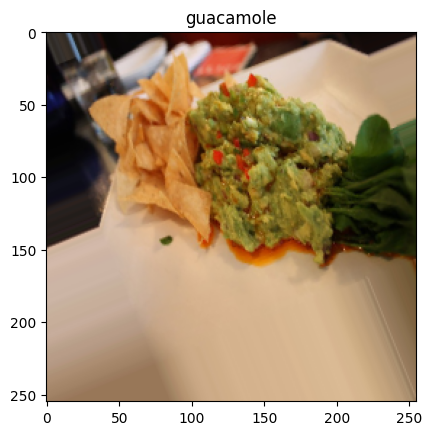

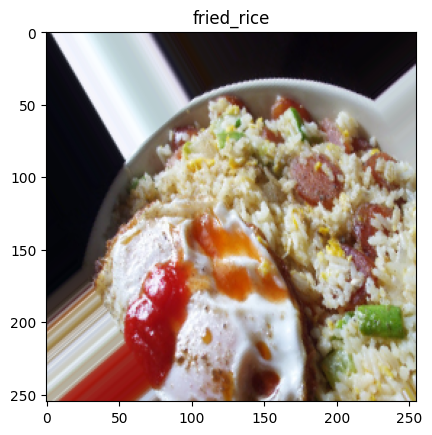

In [6]:
x_batch, y_batch = next(train_datagen)
foldernames = {v:k for k,v in train_datagen.class_indices.items()}
for i in range(0, 2):
    image = x_batch[i]
    plt.imshow(image)
    plt.title(foldernames[y_batch[i].argmax()])
    plt.show()

## Creating the Neural Network

In [7]:
# Train the model

base_model = Xception(weights='imagenet', include_top=False, input_shape=(255,255,3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(101, activation='softmax'))

model.summary()

optimizers = Adam(learning_rate=0.0001)

callbacks = [EarlyStopping(patience=5, verbose=1), ModelCheckpoint('best_model.h5.keras', save_best_only=True, verbose=1), ReduceLROnPlateau(factor=0.1, patience=30, verbose=1), TensorBoard(log_dir='logs')]

model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [10]:
# Train the model
history = model.fit(train_datagen,steps_per_epoch=1000, validation_data=val_datagen, epochs=50, callbacks=callbacks)

# Save the model
model.save('model.h5')

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1156 - loss: 4.0241 
Epoch 1: val_loss improved from inf to 1.82976, saving model to best_model.h5.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14818s 15s/step - accuracy: 0.1157 - loss: 4.0234 - val_accuracy: 0.5408 - val_loss: 1.8298 - learning_rate: 1.0000e-04
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5159 - loss: 1.9320 
Epoch 2: val_loss improved from 1.82976 to 1.35961, saving model to best_model.h5.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14732s 15s/step - accuracy: 0.5159 - loss: 1.9319 - val_accuracy: 0.6524 - val_loss: 1.3596 - learning_rate: 1.0000e-04
Epoch 3/50
  20/1000 ━━━━━━━━━━━━━━━━━━━━ 3:31:56 13s/step - accuracy: 0.6055 - loss: 1.4882

C:\Users\ddieudonne\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 3: val_loss did not improve from 1.35961
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2030s 2s/step - accuracy: 0.6261 - loss: 1.4221 - val_accuracy: 0.6510 - val_loss: 1.3637 - learning_rate: 1.0000e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6265 - loss: 1.4724 
Epoch 4: val_loss improved from 1.35961 to 1.22369, saving model to best_model.h5.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14773s 15s/step - accuracy: 0.6266 - loss: 1.4723 - val_accuracy: 0.6903 - val_loss: 1.2237 - learning_rate: 1.0000e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6765 - loss: 1.2539 
Epoch 5: val_loss improved from 1.22369 to 1.15826, saving model to best_model.h5.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14581s 15s/step - accuracy: 0.6765 - loss: 1.2539 - val_accuracy: 0.7050 - val_loss: 1.1583 - learning_rate: 1.0000e-04
Epoch 6/50
  20/1000 ━━━━━━━━━━━━━━━━━━━━ 3:29:56 13s/step - accuracy: 0.7335 - loss: 1.0833
Epoch 6: val_loss improved from 1.15826 to 1.13811, sa

ValueError: Unable to synchronously create dataset (name already exists)

In [1]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined